In [1]:
!git clone --depth 1 https://github.com/Hzzone/MTLFace.git
!mv MTLFace/python_package/* .
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
import torch
import os.path as osp
torch.cuda.set_device(0)
import torch.nn.functional as F
from PIL import Image
from mtlface.modules import MTLFace
torch.autograd.set_grad_enabled(False)

Cloning into 'MTLFace'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 55 (delta 2), reused 45 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (55/55), 3.37 MiB | 19.40 MiB/s, done.
Resolving deltas: 100% (2/2), done.


pretrained model
https://drive.google.com/file/d/1OmfAjP3BAqVxaQ2pwyJuOYUHy_incMNd/view?usp=share_link
https://pan.baidu.com/s/1GT95OPNR-7GQPMSFFVqzeQ?pwd=wizs

In [2]:
!pip install -U --no-cache-dir gdown --pre
!gdown --id 1OmfAjP3BAqVxaQ2pwyJuOYUHy_incMNd -O mtlface_checkpoints.tar

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1OmfAjP3BAqVxaQ2pwyJuOYUHy_incMNd
From (redirected): https://drive.google.com/uc?id=1OmfAjP3BAqVxaQ2pwyJuOYUHy_incMNd&confirm=t&uuid=a68ff763-cf3b-4054-9717-a6e6dde1baed
To: /content/mtlface_checkpoints.tar
100% 1.09G/1.09G [00:19<00:00, 56.9MB/s]


In [3]:
!pip install Ninja
!echo "from mtlface.stylegan2.op import upfirdn2d, FusedLeakyReLU, fused_leaky_relu" > colab_init.py
!python colab_init.py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 18.4 MB/s eta 0:00:00
Using /root/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py311_cu124/fused...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py311_cu124/fused/build.ninja...
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module fused...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
[1/3] c++ -MMD -MF fused_bias_act.o.d -DTORCH_EXTENSION_NAME=fused -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/

# Face Alignment

In [40]:
# !pip install dlib
from mtlface.face_aligment import face_process

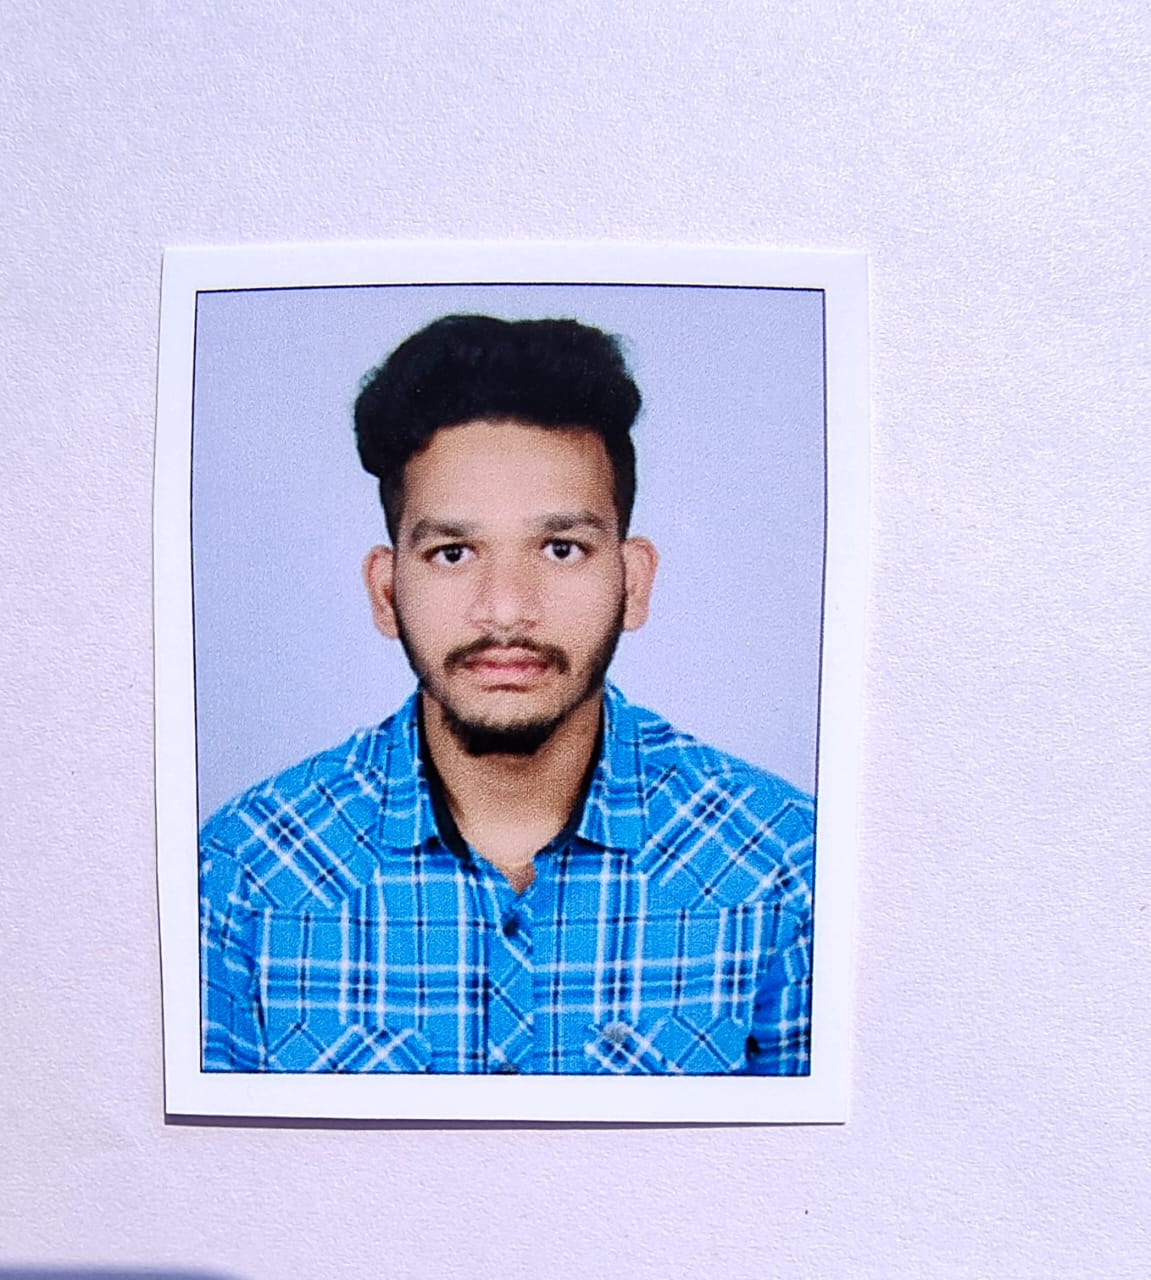

In [75]:
img_path = '13.jpg'
Image.open(img_path)

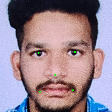

In [76]:
face_process(img_path, plot=True)

-----

In [77]:
mtlface = MTLFace().cuda().eval()
mtlface.load_state_dict(torch.load('mtlface_checkpoints.tar'))

<All keys matched successfully>

In [83]:
from PIL import Image
from torchvision import transforms
import torch
import os.path as osp

images = []
for fname in ['c1.jpg', '13.jpg']:
    path = osp.join(fname)
    input_img = Image.open(path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((112, 112)),  # Resize to match model expectation
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5], inplace=True)
    ])
    input_img = transform(input_img).unsqueeze(0)
    images.append(input_img.cuda())

images = torch.cat(images, dim=0)

# Now this should work if the model expects 112x112 inputs
x_vec, x_age = mtlface.encode(images)


In [84]:
x_vec, x_age = mtlface.encode(images)

# Face Recognition

In [85]:
(x_vec[0] * x_vec[1]).sum() # cosine similarity

tensor(0.2495, device='cuda:0')

# Age Estimation

In [86]:
x_age

tensor([32.6797, 26.9406], device='cuda:0')

# Face Age Synthesis

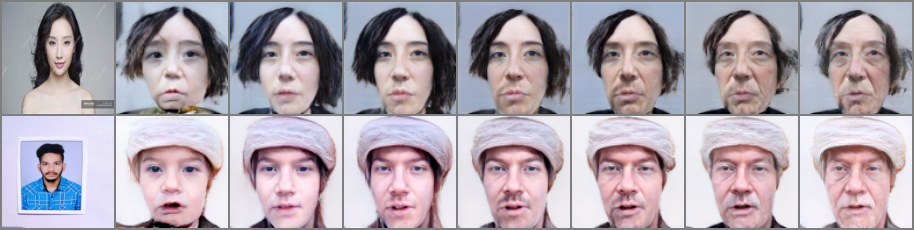

In [87]:
bs = images.size(0)
target_labels = torch.arange(7).cuda().unsqueeze(1).repeat(bs, 1).flatten()
repeat_images = images.unsqueeze(1).repeat(1, 7, 1, 1, 1).view(-1, 3, 112, 112)
outputs = mtlface.aging(repeat_images, target_labels).view(bs, 7, 3, 112, 112)
outputs = torch.cat([images.unsqueeze(1), outputs], dim=1).view(-1, 3, 112, 112)
to_pil_image(make_grid(outputs) * 0.5 + 0.5)